# INSURANCE CLAIM PROBABILITY BASED ON  POLICY FEATURES AND SAFETY RATINGS

## Problem Statement
Insurance companies face the challenge of accurately predicting the likelihood of claims on car insurance policies. With a variety of factors influencing claim frequency and severity, it is difficult to assess risk and determine appropriate premiums for policyholders. The problem arises from the complexity and variety of data involved, including demographic details, vehicle specifications, and past claim histories. Inaccurate predictions can lead to suboptimal premium pricing, financial loss, and inefficient claim management.

The goal of this project is to develop a predictive model that analyzes this complex dataset to predict whether a car insurance claim will occur within a six-month period. The expected output is a model capable of accurately classifying policies into two categories: those likely to file a claim and those unlikely to do so. The model will provide actionable insights into the factors that contribute to the likelihood of claims.

In [1]:
# Importing required packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data Overview

In [2]:
# importing data using pandas
data = pd.read_csv(r'data/Data.csv')
data.shape

(58592, 44)

### a. Feature enginnering

In [8]:
# outliers

<Axes: xlabel='age_of_car'>

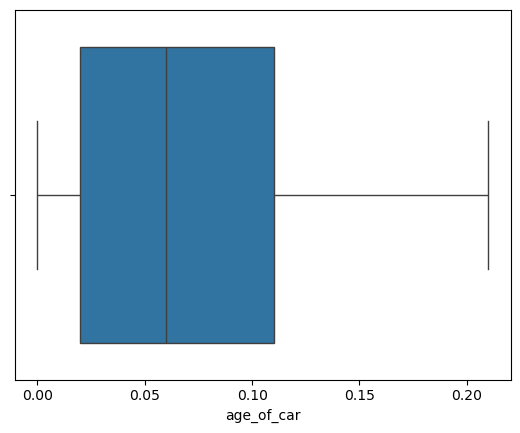

In [9]:
# Removing outliers from age_of_car column which are above 99th percentile
extreme_age_indices = data['age_of_car'] > data['age_of_car'].quantile(0.99)
sns.boxplot(x='age_of_car', data=data.loc[~extreme_age_indices])

<Axes: xlabel='age_of_policyholder'>

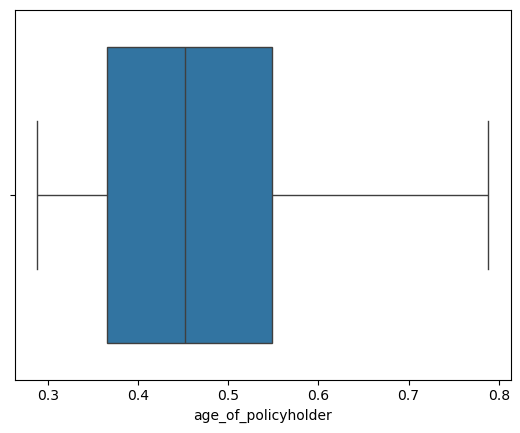

In [10]:
# Removing outliers from age_of_car column which are above 99th percentile
extreme_age_of_policyholder_indices = data['age_of_policyholder'] > data['age_of_policyholder'].quantile(0.99)
sns.boxplot(x='age_of_policyholder', data=data.loc[~extreme_age_of_policyholder_indices])

In [11]:
data=data.loc[~extreme_age_of_policyholder_indices]
data = data.loc[~extreme_age_indices]

In [3]:
data = data.drop(['policy_id'],axis =1)

In [12]:
## converting columns into categorical that has less than 10 unique values

for col in list(data.columns):
    if len(data[col].unique()) < 10:
        data[col] = data[col].astype('object')

In [5]:
data['population_density'] = data['population_density'].astype('float64')

In [6]:
# length, width, height can be represented as one column that is volume
data['volume'] = np.log(data['length'].astype('int64')*data['width']*data['height']*1e-6)
data = data.drop(['length','width','height'],axis=1)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57550 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_tenure                     57550 non-null  float64
 1   age_of_car                        57550 non-null  float64
 2   age_of_policyholder               57550 non-null  float64
 3   area_cluster                      57550 non-null  object 
 4   population_density                57550 non-null  float64
 5   make                              57550 non-null  object 
 6   segment                           57550 non-null  object 
 7   model                             57550 non-null  object 
 8   fuel_type                         57550 non-null  object 
 9   max_torque                        57550 non-null  object 
 10  max_power                         57550 non-null  object 
 11  engine_type                       57550 non-null  object 
 12  airbags  

## Multi-Collinearity of numerical features

In [14]:
cat_cols = list(data.select_dtypes('object').columns)
print(cat_cols)

['area_cluster', 'make', 'segment', 'model', 'fuel_type', 'max_torque', 'max_power', 'engine_type', 'airbags', 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type', 'displacement', 'cylinder', 'transmission_type', 'gear_box', 'steering_type', 'turning_radius', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim']


<Axes: >

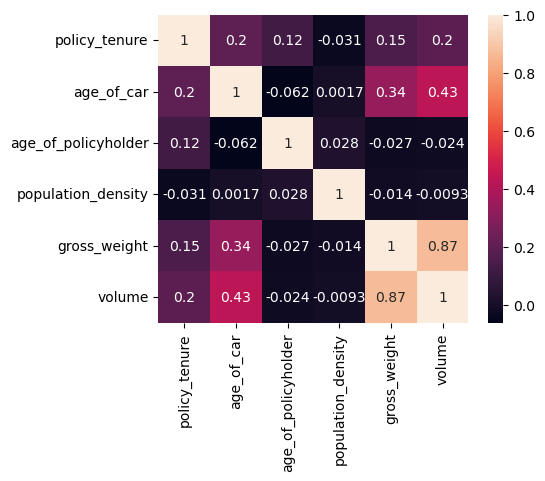

In [15]:
plt.figure(figsize=(5,4))
sns.heatmap(data.select_dtypes(exclude='object').corr(method='spearman'),annot=True)

It appears `gross_weight` and `volume` are highly correlated.

In [16]:
# remvoving gross_weight column
data = data.drop(['gross_weight'],axis = 1)

**There is no Multi-Collineairty in the numerical features**

## Mutual Information

In [15]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

In [92]:
le = LabelEncoder()
for col in list(data.select_dtypes(include='object')):
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    
data.head()

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,...,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,volume
0,0.515874,0.05,0.644231,0,4990.0,0,0,0,0,5,...,0,0,1,0,0,0,1,0,0,8.948753
1,0.672619,0.02,0.375000,11,27003.0,0,0,0,0,5,...,0,0,1,0,0,0,1,0,0,8.948753
2,0.841110,0.02,0.384615,15,4076.0,0,0,0,0,5,...,0,0,1,0,0,0,1,0,0,8.948753
3,0.900277,0.11,0.432692,16,21622.0,0,3,3,2,0,...,1,1,1,1,1,1,1,1,0,9.259222
4,0.596403,0.11,0.634615,17,34738.0,1,0,4,2,8,...,1,1,1,0,1,1,1,1,0,9.079999


In [85]:
X = data.drop(['is_claim'], axis = 1)
y = data['is_claim'].astype('int64')

In [33]:
y

0        0
1        0
2        0
3        0
4        0
        ..
58587    0
58588    0
58589    0
58590    0
58591    0
Name: is_claim, Length: 55229, dtype: int64

In [125]:
k

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [50]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category","bool"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    all_mi_scores = []
    for random_state in range(0, 5):
        mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=random_state)
        all_mi_scores.append(mi_scores)
    all_mi_scores = np.mean(all_mi_scores, axis=0)
    all_mi_scores = pd.Series(all_mi_scores, name="MI Scores", index=X.columns)
    all_mi_scores = all_mi_scores.sort_values(ascending=False)
    return all_mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [31]:
y

0        0
1        0
2        0
3        0
4        0
        ..
58587    0
58588    0
58589    0
58590    0
58591    0
Name: is_claim, Length: 55229, dtype: object

In [18]:
mi_scores = make_mi_scores(data.drop('is_claim', axis=1), y)

In [36]:
mi_scores

policy_tenure                       2.611635e-03
age_of_car                          2.190926e-03
volume                              1.711061e-03
population_density                  1.280138e-03
area_cluster                        8.220007e-04
age_of_policyholder                 6.470667e-04
model                               1.951929e-04
engine_type                         1.951929e-04
max_power                           1.894447e-04
displacement                        1.894447e-04
max_torque                          1.894447e-04
turning_radius                      1.264265e-04
segment                             1.158691e-04
is_adjustable_steering              9.605255e-05
cylinder                            9.200762e-05
is_front_fog_lights                 6.671089e-05
is_brake_assist                     5.913730e-05
make                                5.605925e-05
is_driver_seat_height_adjustable    5.496095e-05
is_parking_sensors                  5.083923e-05
steering_type       

policy_tenure                       0.002585
volume                              0.002372
age_of_car                          0.002180
population_density                  0.002009
area_cluster                        0.000846
age_of_policyholder                 0.000555
model                               0.000192
engine_type                         0.000192
max_power                           0.000186
displacement                        0.000186
max_torque                          0.000186
turning_radius                      0.000126
segment                             0.000112
is_adjustable_steering              0.000095
cylinder                            0.000091
is_front_fog_lights                 0.000065
is_brake_assist                     0.000058
is_driver_seat_height_adjustable    0.000053
make                                0.000049
steering_type                       0.000049
Name: MI Scores, dtype: float64
steering_type                    4.867740e-05
fuel_type             

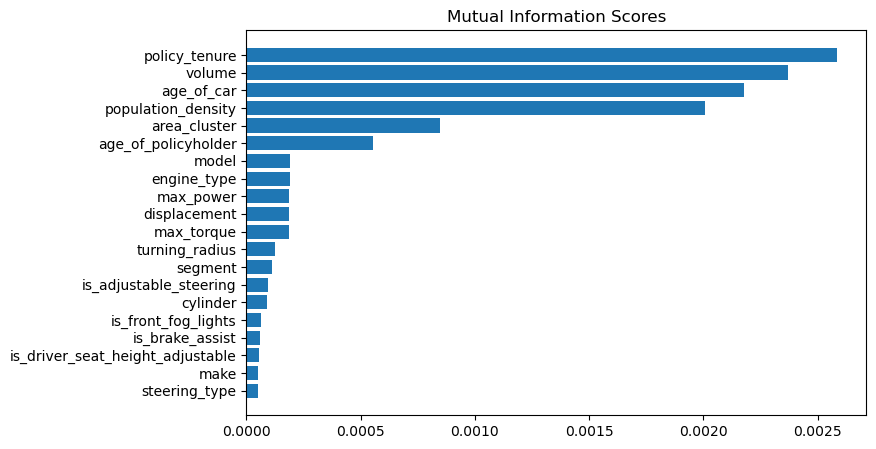

In [19]:
print(mi_scores.head(20))
print(mi_scores.tail(20))
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

**I choose the top 6 columns here**

In [51]:
final_columns = list(mi_scores.iloc[:7].index)
final_columns

['policy_tenure',
 'volume',
 'age_of_car',
 'population_density',
 'area_cluster',
 'age_of_policyholder',
 'model']

## Feature Engineering

### Handling class imbalance

In [94]:
X = X[final_columns]

In [95]:
X.shape

(57550, 13)

In [96]:
y.shape

(57550,)

In [55]:
X

,policy_tenure,volume,age_of_car,population_density,area_cluster,age_of_policyholder,model
0,0.515874,8.948753,0.05,4990.0,C1,0.644231,M1
1,0.672619,8.948753,0.02,27003.0,C2,0.375000,M1
2,0.841110,8.948753,0.02,4076.0,C3,0.384615,M1
3,0.900277,9.259222,0.11,21622.0,C4,0.432692,M2
4,0.596403,9.079999,0.11,34738.0,C5,0.634615,M3
...,...,...,...,...,...,...,...
58587,0.355089,9.079999,0.13,8794.0,C8,0.644231,M3
58588,1.199642,8.948753,0.02,7788.0,C14,0.519231,M1
58589,1.162273,8.948753,0.05,34738.0,C5,0.451923,M1
58590,1.236307,9.230804,0.14,8794.0,C8,0.557692,M6


### Train test split

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [23]:
X_train

,policy_tenure,volume,age_of_car,population_density,area_cluster,age_of_policyholder,model
7131,0.085303,9.440229,0.06,6112.0,C7,0.365385,M4
54700,0.719494,9.440229,0.10,5410.0,C13,0.548077,M4
46680,1.145016,9.202091,0.03,3264.0,C21,0.336538,M8
5262,1.012593,9.230804,0.07,5410.0,C13,0.326923,M6
45095,0.035940,9.079999,0.06,5410.0,C13,0.471154,M3
...,...,...,...,...,...,...,...
55327,0.063640,9.230804,0.00,8794.0,C8,0.528846,M6
38836,0.645955,9.253766,0.04,27742.0,C19,0.432692,M7
872,1.235256,9.230804,0.17,34791.0,C12,0.692308,M6
16074,0.370551,9.230804,0.05,4076.0,C3,0.490385,M6


In [24]:
X_test

,policy_tenure,volume,age_of_car,population_density,area_cluster,age_of_policyholder,model
8950,1.003492,8.948753,0.01,4990.0,C1,0.365385,M1
16085,0.436722,8.948753,0.04,73430.0,C10,0.538462,M1
56122,1.221547,9.079999,0.12,8794.0,C8,0.480769,M3
56672,0.143468,9.440229,0.19,8794.0,C8,0.605769,M4
11125,0.379891,8.948753,0.00,73430.0,C10,0.394231,M1
...,...,...,...,...,...,...,...
51956,1.203196,9.202091,0.08,7788.0,C14,0.480769,M8
50664,0.463661,8.948753,0.03,34738.0,C5,0.519231,M1
56146,0.132270,8.948753,0.01,73430.0,C10,0.298077,M1
54013,1.007204,8.948753,0.01,7788.0,C14,0.451923,M1


In [47]:
y_train

27935    0
8314     0
17678    0
35104    0
42670    1
        ..
47430    0
57655    0
40429    0
904      0
16742    0
Name: is_claim, Length: 44183, dtype: int64

In [82]:
final_columns

['policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'max_torque',
 'max_power',
 'displacement',
 'area_cluster',
 'make',
 'segment',
 'model',
 'fuel_type',
 'engine_type',
 'rear_brakes_type',
 'transmission_type',
 'steering_type']

In [57]:
# Categorical columns
cat_cols = ['model','area_cluster']

num_cols = ['policy_tenure','volume','age_of_car', 'age_of_policyholder','population_density']

In [92]:
num_cols = ['policy_tenure', 'age_of_car', 'age_of_policyholder', 'displacement']
cat_cols = ['area_cluster', 'make', 'segment', 'model', 'fuel_type', 'engine_type', 'rear_brakes_type', 'transmission_type', 'steering_type']


In [93]:
final_columns = num_cols+cat_cols

In [58]:
cat_cols

['model', 'area_cluster']

In [60]:
num_cols

['policy_tenure',
 'volume',
 'age_of_car',
 'age_of_policyholder',
 'population_density']

In [97]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('scaler', StandardScaler()), ('power', PowerTransformer())]), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

In [83]:
X_train

,policy_tenure,volume,age_of_car,population_density,area_cluster,age_of_policyholder,model
7131,0.085303,9.440229,0.06,6112.0,C7,0.365385,M4
54700,0.719494,9.440229,0.10,5410.0,C13,0.548077,M4
46680,1.145016,9.202091,0.03,3264.0,C21,0.336538,M8
5262,1.012593,9.230804,0.07,5410.0,C13,0.326923,M6
45095,0.035940,9.079999,0.06,5410.0,C13,0.471154,M3
...,...,...,...,...,...,...,...
55327,0.063640,9.230804,0.00,8794.0,C8,0.528846,M6
38836,0.645955,9.253766,0.04,27742.0,C19,0.432692,M7
872,1.235256,9.230804,0.17,34791.0,C12,0.692308,M6
16074,0.370551,9.230804,0.05,4076.0,C3,0.490385,M6


In [98]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [99]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [100]:
sme = SMOTE(random_state=42)
X_res, y_res = sme.fit_resample(X_train_transformed, y_train)

In [122]:
print("Before resampling: ", Counter(y_train))
print("After resampling: ", Counter(y_res))

Before resampling:  Counter({0: 43098, 1: 2942})
After resampling:  Counter({0: 43098, 1: 43098})


## Encoding categorical variables

In [32]:
X_res = preprocessor.fit_transform(X_res)
X_test = preprocessor.transform(X_test)

In [33]:
X_res

array([[2.85714286e-01, 1.53846154e-01, 5.92349692e-02, ...,
        9.43700000e+03, 1.90000000e+01, 5.00000000e+00],
       [4.76190476e-01, 5.19230769e-01, 5.14208791e-01, ...,
        9.43700000e+03, 4.00000000e+00, 5.00000000e+00],
       [1.42857143e-01, 9.61538462e-02, 8.19481726e-01, ...,
        1.84600000e+03, 1.30000000e+01, 9.00000000e+00],
       ...,
       [6.62565603e-01, 4.45788854e-01, 3.60409481e-01, ...,
        4.92600000e+03, 2.00000000e+01, 7.00000000e+00],
       [3.21532708e-01, 7.86866215e-02, 8.81500354e-01, ...,
        9.43700000e+03, 1.10000000e+01, 5.00000000e+00],
       [9.52380952e-02, 5.38590564e-01, 2.92020960e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [70]:
X_test

array([[2.38095238e-01, 9.30232558e-02, 8.77710051e-01, ...,
        9.03800000e+03, 1.10000000e+01, 5.00000000e+00],
       [3.80952381e-01, 4.65116279e-02, 7.44408105e-01, ...,
        7.05800000e+03, 2.00000000e+01, 8.00000000e+00],
       [6.66666667e-01, 3.25581395e-01, 7.94708474e-01, ...,
        4.68300000e+03, 1.00000000e+00, 7.00000000e+00],
       ...,
       [6.19047619e-01, 9.30232558e-02, 3.02958438e-01, ...,
        4.68300000e+03, 4.00000000e+00, 7.00000000e+00],
       [6.19047619e-01, 3.72093023e-01, 7.53770705e-01, ...,
        4.68300000e+03, 2.00000000e+01, 7.00000000e+00],
       [0.00000000e+00, 6.27906977e-01, 5.69093098e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [88]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for i in list(X_train.iloc[:,:4].columns):
    X_train[i] = scaler.fit_transform(X_train[[i]])
    X_test[i] = scaler.transform(X_test[[i]])


## Model Training

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

In [70]:
def evaluation(true,predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    return acc, f1 , precision, recall
    

In [115]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     #"Support Vector Classifier": SVC(),
    #"AdaBoost Classifier": AdaBoostClassifier()
}

In [71]:
list(models.values())[1]

DecisionTreeClassifier()

In [116]:
def train_evaluate_models(X_train,y_train,X_test,y_test,models):
    
    model_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train,y_train)
        
        y_train_predicted = model.predict(X_train)
        y_test_predicted = model.predict(X_test)
        
        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall = evaluation(y_train,y_train_predicted)
        
        # Test set performance
        model_test_accuracy, model_test_f1, model_test_precision, model_test_recall = evaluation(y_test,y_test_predicted)
        
        
        print(list(models.keys())[i])
        model_list.append(list(models.keys())[i])
        
        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        
        print('='*35)
        print('\n')
        
    report = pd.DataFrame(list(zip(model_list,accuracy_list)),columns = ['Model name','Accuracy']).sort_values(by=['Accuracy'],ascending=False)
    return report
        

        
        

In [118]:
base_model_report = train_evaluate_models(X_train=X_res,y_train=y_res,X_test=X_test_transformed,y_test=y_test,models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8728
- F1 score: 0.1062
- Precision: 0.0961
- Recall: 0.1187


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8591
- F1 score: 0.1029
- Precision: 0.0865
- Recall: 0.1269


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8220
- F1 score: 0.8224
- Precision: 0.8205
- Recall: 0.8243
----------------------------------
Model performance for Test set
- Accuracy: 0.7847
- F1 score: 0.1473
- Precision: 0.0985
- Recall: 0.2920


Logistic Regression
Model performance for Training set
- Accuracy: 0.5899
- F1 score: 0.6005
- Precision: 0.5853
- Recall: 0.6166
----------------------------------
Model performance for Test set

In [ ]:
base_model_report

In [121]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights to handle imbalanced classes (optional)
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight_dict = dict(zip([0, 1], class_weights))

model = RandomForestClassifier(
    n_estimators=100,            # Number of trees
    max_depth=10,                # Maximum depth of the tree to prevent overfitting
    min_samples_split=10,        # Minimum samples required to split a node
    min_samples_leaf=5,          # Minimum samples required at leaf node
    max_features='sqrt',         # Limit the number of features used in each split
    class_weight=class_weight_dict,  # Class weights to handle class imbalance
    random_state=42
)
model.fit(X_res,y_res)
        
y_train_predicted = model.predict(X_res)
y_test_predicted = model.predict(X_test_transformed)
        
        # Training set performance
model_train_accuracy, model_train_f1, model_train_precision, model_train_recall = evaluation(y_res,y_train_predicted)
        
        # Test set performance
model_test_accuracy, model_test_f1, model_test_precision, model_test_recall = evaluation(y_test,y_test_predicted)
        
        
print('Model performance for Training set')
print("- Accuracy: {:.4f}".format(model_train_accuracy))       
print('- F1 score: {:.4f}'.format(model_train_f1)) 
print('- Precision: {:.4f}'.format(model_train_precision))
print('- Recall: {:.4f}'.format(model_train_recall))

print('----------------------------------')

print('Model performance for Test set')
print('- Accuracy: {:.4f}'.format(model_test_accuracy))
print('- F1 score: {:.4f}'.format(model_test_f1))
print('- Precision: {:.4f}'.format(model_test_precision))
print('- Recall: {:.4f}'.format(model_test_recall))

Model performance for Training set
- Accuracy: 0.5101
- F1 score: 0.6712
- Precision: 0.5051
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.0787
- F1 score: 0.1213
- Precision: 0.0646
- Recall: 0.9986


In [66]:
X_test_transformed

array([[4.76190476e-02, 1.53846154e-01, 7.17951556e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.90476190e-01, 5.00000000e-01, 3.11345990e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [5.71428571e-01, 3.84615385e-01, 8.74386258e-01, ...,
        1.00000000e+00, 2.00000000e+01, 4.00000000e+00],
       ...,
       [4.76190476e-02, 1.92307692e-02, 9.29295217e-02, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [4.76190476e-02, 3.26923077e-01, 7.20614666e-01, ...,
        0.00000000e+00, 5.00000000e+00, 0.00000000e+00],
       [1.90476190e-01, 0.00000000e+00, 2.08342676e-01, ...,
        5.00000000e+00, 2.00000000e+01, 7.00000000e+00]])

In [114]:
model = XGBClassifier(n_estimators=100,eval_metric="logloss", random_state=42, max_depth = 2, alpha = 10)
model.fit(X_res,y_res)
        
y_train_predicted = model.predict(X_res)
y_test_predicted = model.predict(X_test_transformed)
        
        # Training set performance
model_train_accuracy, model_train_f1, model_train_precision, model_train_recall = evaluation(y_res,y_train_predicted)
        
        # Test set performance
model_test_accuracy, model_test_f1, model_test_precision, model_test_recall = evaluation(y_test,y_test_predicted)
        
        
print('Model performance for Training set')
print("- Accuracy: {:.4f}".format(model_train_accuracy))       
print('- F1 score: {:.4f}'.format(model_train_f1)) 
print('- Precision: {:.4f}'.format(model_train_precision))
print('- Recall: {:.4f}'.format(model_train_recall))

print('----------------------------------')

print('Model performance for Test set')
print('- Accuracy: {:.4f}'.format(model_test_accuracy))
print('- F1 score: {:.4f}'.format(model_test_f1))
print('- Precision: {:.4f}'.format(model_test_precision))
print('- Recall: {:.4f}'.format(model_test_recall))

Model performance for Training set
- Accuracy: 0.8349
- F1 score: 0.8244
- Precision: 0.8802
- Recall: 0.7753
----------------------------------
Model performance for Test set
- Accuracy: 0.8468
- F1 score: 0.1487
- Precision: 0.1151
- Recall: 0.2101


In [103]:
model_xgb = XGBClassifier(n_estimators=500, random_state=42)

In [104]:
model_xgb.fit(X_res, y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [105]:
preds = model_xgb.predict(X_test_transformed)

In [77]:
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

In [106]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10777
           1       0.10      0.04      0.06       733

    accuracy                           0.92     11510
   macro avg       0.52      0.51      0.51     11510
weighted avg       0.88      0.92      0.90     11510



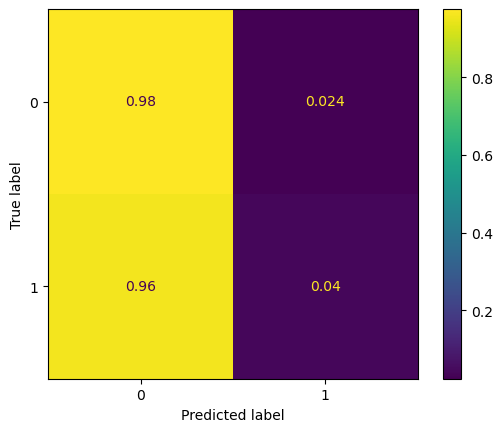

In [107]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='true')